In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)

import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv('../input/champs-scalar-coupling/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4659076, 5)
Total:  88522828


Index                       37272608
molecule_index              18636304
atom_index_0                4659076 
atom_index_1                4659076 
type                        4659460 
scalar_coupling_constant    18636304
dtype: int64

In [6]:
test_csv = pd.read_csv('../input/test-data/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [7]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv('../input/champs-scalar-coupling/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [8]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358875, 6)
Total:  42459878


Index             128    
molecule_index    9435500
atom_index        2358875
atom              2358875
x                 9435500
y                 9435500
z                 9435500
dtype: int64

In [9]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [10]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [11]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [12]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [13]:
# 原子对的中心距离
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))
#原子到中心点的距离
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [14]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [15]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [16]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [17]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [18]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [19]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [20]:
# Set up GPU preferences
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

Training 1JHC out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
312/312 [==============================] - 8s 18ms/step - loss: 81.6885 - val_loss: 19.1820
Epoch 2/1000
312/312 [==============================] - 5s 16ms/step - loss: 2.0744 - val_loss: 2.3171
Epoch 3/1000
312/312 [==============================] - 5s 16ms/step - loss: 1.6350 - val_loss: 1.7738
Epoch 4/1000
312/312 [==============================] - 5s 16ms/step - loss: 1.5261 - val_loss: 1.8540
Epoch 5/1000
312/312 [==============================] - 5s 16ms/step - loss: 1.4397 - val_loss: 1.4635
Epoch 6/1000
312/312 [==============================] - 5s 17ms/step - loss: 1.3463 - val_loss: 1.4562
Epoch 7/1000
312/312 [==============================] - 5s 16ms/step - loss: 1.3142 - val_loss: 1.5465
Epoch 8/1000
312/312 [==============================] - 5s 16ms/step - loss: 1.2895 - val_loss: 1.65

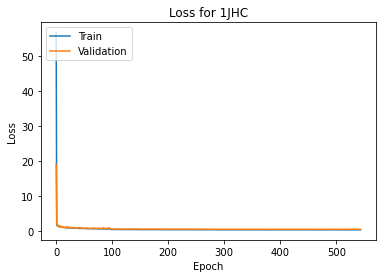

-0.47094947
Training 2JHH out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
167/167 [==============================] - 4s 18ms/step - loss: 7.4768 - val_loss: 0.9932
Epoch 2/1000
167/167 [==============================] - 3s 16ms/step - loss: 0.4999 - val_loss: 0.8140
Epoch 3/1000
167/167 [==============================] - 3s 16ms/step - loss: 0.4271 - val_loss: 0.5156
Epoch 4/1000
167/167 [==============================] - 3s 16ms/step - loss: 0.3747 - val_loss: 0.4742
Epoch 5/1000
167/167 [==============================] - 3s 18ms/step - loss: 0.3539 - val_loss: 0.5541
Epoch 6/1000
167/167 [==============================] - 3s 17ms/step - loss: 0.3441 - val_loss: 0.4818
Epoch 7/1000
167/167 [==============================] - 3s 17ms/step - loss: 0.3234 - val_loss: 0.4306
Epoch 8/1000
167/167 [==============================] - 3s 17ms/step - loss: 0.2962 - val_

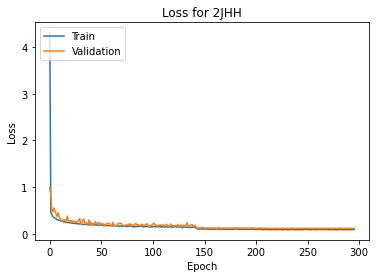

-2.1613662
Training 1JHN out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
20/20 [==============================] - 2s 30ms/step - loss: 47.3451 - val_loss: 46.5478
Epoch 2/1000
20/20 [==============================] - 0s 18ms/step - loss: 46.3835 - val_loss: 44.8295
Epoch 3/1000
20/20 [==============================] - 0s 18ms/step - loss: 44.8197 - val_loss: 42.1449
Epoch 4/1000
20/20 [==============================] - 0s 18ms/step - loss: 42.3811 - val_loss: 38.3996
Epoch 5/1000
20/20 [==============================] - 0s 22ms/step - loss: 38.9229 - val_loss: 33.5097
Epoch 6/1000
20/20 [==============================] - 0s 20ms/step - loss: 34.4468 - val_loss: 32.0762
Epoch 7/1000
20/20 [==============================] - 0s 18ms/step - loss: 29.0324 - val_loss: 49.7285
Epoch 8/1000
20/20 [==============================] - 0s 18ms/step - loss: 22.3671 - val_lo

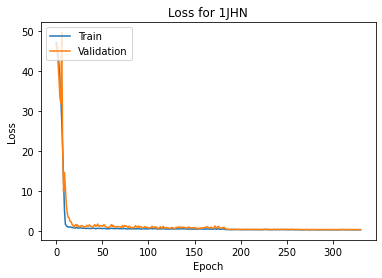

-1.1003686
Training 2JHN out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
53/53 [==============================] - 3s 23ms/step - loss: 2.9049 - val_loss: 2.1905
Epoch 2/1000
53/53 [==============================] - 1s 17ms/step - loss: 0.9254 - val_loss: 1.6068
Epoch 3/1000
53/53 [==============================] - 1s 16ms/step - loss: 0.4400 - val_loss: 1.3975
Epoch 4/1000
53/53 [==============================] - 1s 17ms/step - loss: 0.3814 - val_loss: 1.1870
Epoch 5/1000
53/53 [==============================] - 1s 17ms/step - loss: 0.3336 - val_loss: 0.8408
Epoch 6/1000
53/53 [==============================] - 1s 17ms/step - loss: 0.3149 - val_loss: 0.6543
Epoch 7/1000
53/53 [==============================] - 1s 17ms/step - loss: 0.2903 - val_loss: 0.4792
Epoch 8/1000
53/53 [==============================] - 1s 16ms/step - loss: 0.2899 - val_loss: 0.4240
Epoc

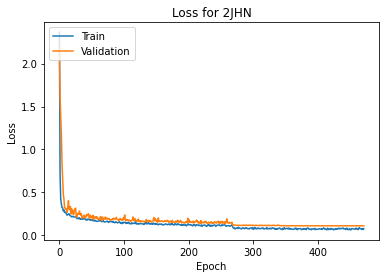

-2.1901865
Training 2JHC out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
502/502 [==============================] - 10s 17ms/step - loss: 1.1019 - val_loss: 0.7833
Epoch 2/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.6116 - val_loss: 0.5917
Epoch 3/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.5463 - val_loss: 0.5236
Epoch 4/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.5038 - val_loss: 0.5305
Epoch 5/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.4751 - val_loss: 0.4815
Epoch 6/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.4525 - val_loss: 0.4805
Epoch 7/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.4321 - val_loss: 0.4183
Epoch 8/1000
502/502 [==============================] - 8s 16ms/step - loss: 0.4201 - val_

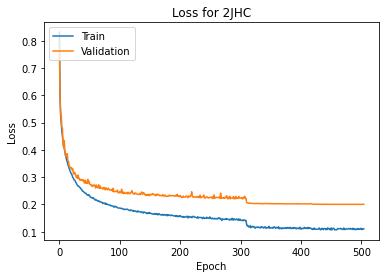

-1.607858
Training 3JHH out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
260/260 [==============================] - 6s 17ms/step - loss: 2.6837 - val_loss: 1.8561
Epoch 2/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.4582 - val_loss: 0.4498
Epoch 3/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.4005 - val_loss: 0.4329
Epoch 4/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.3551 - val_loss: 0.4084
Epoch 5/1000
260/260 [==============================] - 4s 17ms/step - loss: 0.3418 - val_loss: 0.3724
Epoch 6/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.3227 - val_loss: 0.3779
Epoch 7/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.3129 - val_loss: 0.3546
Epoch 8/1000
260/260 [==============================] - 4s 16ms/step - loss: 0.3056 - val_lo

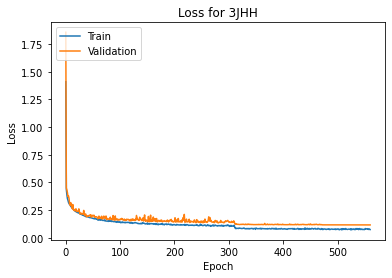

-2.1478362
Training 3JHC out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
665/665 [==============================] - 14s 17ms/step - loss: 1.5223 - val_loss: 0.7641
Epoch 2/1000
665/665 [==============================] - 12s 17ms/step - loss: 0.6137 - val_loss: 0.6165
Epoch 3/1000
665/665 [==============================] - 11s 17ms/step - loss: 0.5450 - val_loss: 0.5302
Epoch 4/1000
665/665 [==============================] - 11s 17ms/step - loss: 0.5060 - val_loss: 0.5059
Epoch 5/1000
665/665 [==============================] - 12s 18ms/step - loss: 0.4755 - val_loss: 0.4876
Epoch 6/1000
665/665 [==============================] - 11s 17ms/step - loss: 0.4527 - val_loss: 0.4570
Epoch 7/1000
665/665 [==============================] - 11s 17ms/step - loss: 0.4379 - val_loss: 0.4446
Epoch 8/1000
665/665 [==============================] - 12s 18ms/step - loss: 0.4220

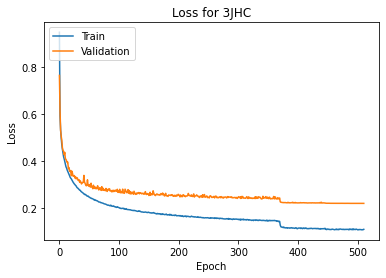

-1.5135583
Training 3JHN out of ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
Categories (8, object): ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 

Epoch 1/1000
74/74 [==============================] - 3s 21ms/step - loss: 1.0870 - val_loss: 0.8171
Epoch 2/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.3642 - val_loss: 0.7970
Epoch 3/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.3006 - val_loss: 0.7104
Epoch 4/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.2721 - val_loss: 0.6052
Epoch 5/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.2575 - val_loss: 0.4515
Epoch 6/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.2291 - val_loss: 0.3454
Epoch 7/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.2210 - val_loss: 0.2457
Epoch 8/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.2061 - val_loss: 0.2475
Epoc

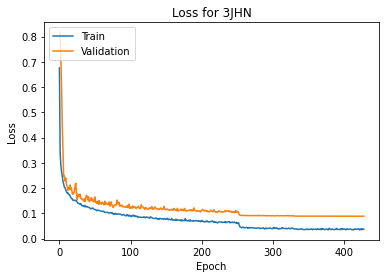

-2.4249797


In [21]:
from datetime import datetime

mol_types=train_csv["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 1
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test_csv))
input_features = ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       'atom_8','atom_9', 'atom_10','d_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2',
       'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3', 'd_10_0', 'd_10_1', 'd_10_2',
       'd_10_3']



# Loop through each molecule type
for mol_type in mol_types:

    model_name_wrt = ('/kaggle/working/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
    full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
    df_train_ = take_n_atoms(full, 11)
    df_test_ = take_n_atoms(full2, 11)
    df_train_  = df_train_.fillna(0)
    df_test_  = df_test_.fillna(0)
    
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
    #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values

    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    # Split all our input and targets by train and cv indexes
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input,[train_target], 
            validation_data=(cv_input,[cv_target]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test_csv["type"]==mol_type]=test_predict[:,0]
    tf.compat.v1.keras.backend.clear_session()

cv_score_total/=len(mol_types)

In [22]:
print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

Total training time:  4:50:47.794398
1JHC : cv score is  -0.47094947
2JHH : cv score is  -2.1613662
1JHN : cv score is  -1.1003686
2JHN : cv score is  -2.1901865
2JHC : cv score is  -1.607858
3JHH : cv score is  -2.1478362
3JHC : cv score is  -1.5135583
3JHN : cv score is  -2.4249797
total cv score is -1.702137865126133


In [23]:
submission_csv = pd.read_csv("../input/test-data/test.csv")
submission_csv['scalar_coupling_constant'] = 1
submission_csv = submission_csv.drop(['molecule_name', 'atom_index_0', 'atom_index_1', 'type'], axis=1)
submission_csv.head()

,id,scalar_coupling_constant
0,4658147,1
1,4658148,1
2,4658149,1
3,4658150,1
4,4658151,1


In [24]:
def submits(predictions):
 
    submission_csv["scalar_coupling_constant"] = predictions
    submission_csv.to_csv("/kaggle/working/submission.csv", index=False)
submits(test_prediction)